In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

# Downloading NLTK stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayesha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [6]:
# Loading the dataset
data = pd.read_csv(r"C:\Users\Ayesha\Downloads\flipkart_data.csv")
print(data.head())


                                              review  rating
0  It was nice produt. I like it's design a lot. ...       5
1  awesome sound....very pretty to see this nd th...       5
2  awesome sound quality. pros 7-8 hrs of battery...       4
3  I think it is such a good product not only as ...       5
4  awesome bass sound quality very good bettary l...       5


In [7]:
# Checking unique ratings
print(pd.unique(data['rating']))


[5 4 1 3 2]


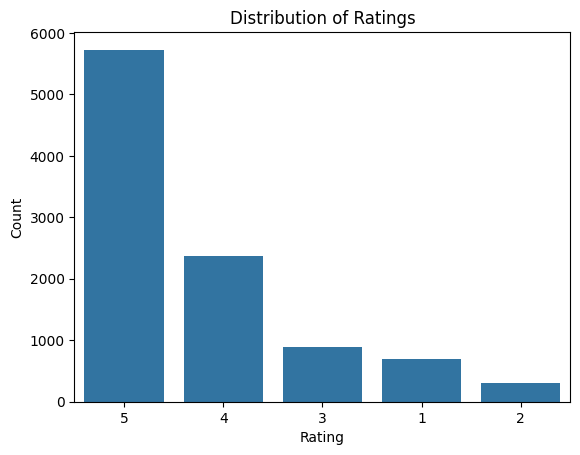

In [8]:
# Countplot for Ratings
sns.countplot(data=data, x='rating', order=data.rating.value_counts().index)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [9]:
# Converting ratings to binary labels (0 or 1)
pos_neg = [1 if rating >= 5 else 0 for rating in data['rating']]
data['label'] = pos_neg


In [11]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ayesha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [12]:
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import re

# Ensure stopwords and punkt are downloaded
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        # Removing punctuations
        sentence = re.sub(r'[^\w\s]', '', sentence)
        
        # Converting to lowercase and removing stopwords
        tokens = nltk.word_tokenize(sentence)
        stop_words = set(stopwords.words('english'))
        filtered_words = [token.lower() for token in tokens if token.lower() not in stop_words]
        preprocessed_text.append(' '.join(filtered_words))

    return preprocessed_text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayesha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ayesha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# Checking counts of positive and negative labels
print(data["label"].value_counts())


label
1    5726
0    4250
Name: count, dtype: int64


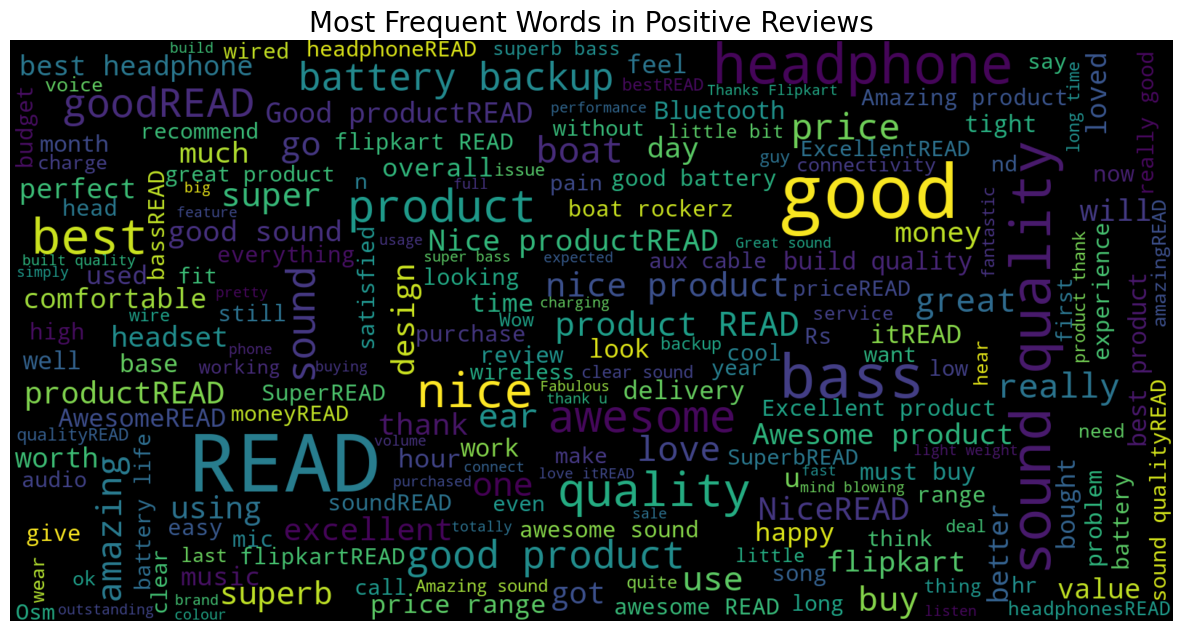

In [14]:
# Creating WordCloud for positive reviews
consolidated = ' '.join(word for word in data['review'][data['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=110)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.title('Most Frequent Words in Positive Reviews', fontsize=20)
plt.axis('off')
plt.show()


In [15]:
# Converting text into TF-IDF vectors
cv = TfidfVectorizer(max_features=2500)
X = cv.fit_transform(data['review']).toarray()
print(X)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
from sklearn.model_selection import train_test_split

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.33, stratify=data['label'], random_state=42)


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Train the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)

# Predicting on training data
pred = model.predict(X_train)
print('Training Accuracy:', accuracy_score(y_train, pred))


Training Accuracy: 0.9367050725721981


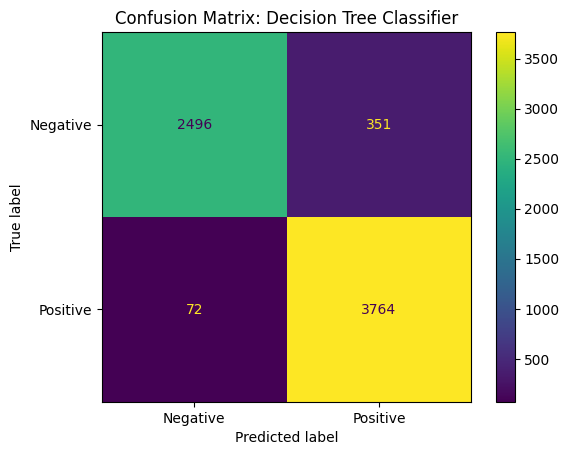

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_train, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

cm_display.plot()
plt.title('Confusion Matrix: Decision Tree Classifier')
plt.show()


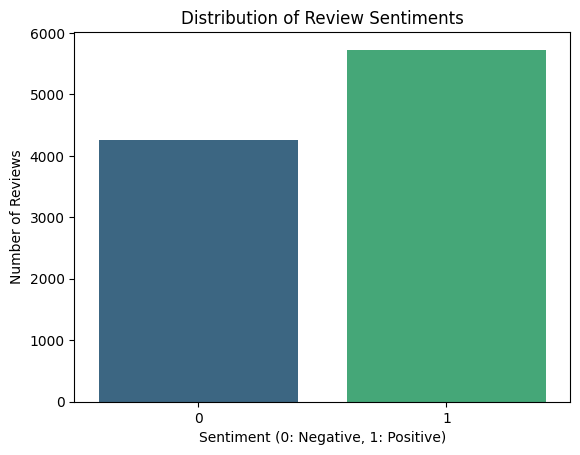

In [21]:
sns.countplot(data=data, x='label', palette='viridis')
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Number of Reviews')
plt.show()


In [22]:
sample_reviews = data[['review', 'label']].sample(10)
print(sample_reviews)


                                                 review  label
7137  It's very hurt when you put it on over the hea...      0
8283  guys its audio quality is awesome, fit is awes...      0
4292                     Nice 👍 ha happy ha 👌👌READ MORE      1
3533                                   AwesomeREAD MORE      1
7283                              Best productREAD MORE      0
4223  Nice quality  sound very good  and battery bac...      1
1290  Bought at 1399Sound good 3.5/5Bass good 4/5Con...      0
3016  No return policy Sound comes out from headphon...      0
126   Thank you Flipkart for Fast delivery and sound...      1
3244                          999 price its okREAD MORE      0


In [23]:
from sklearn.metrics import classification_report
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.67      0.55      0.61      1403
    Positive       0.71      0.80      0.75      1890

    accuracy                           0.69      3293
   macro avg       0.69      0.68      0.68      3293
weighted avg       0.69      0.69      0.69      3293



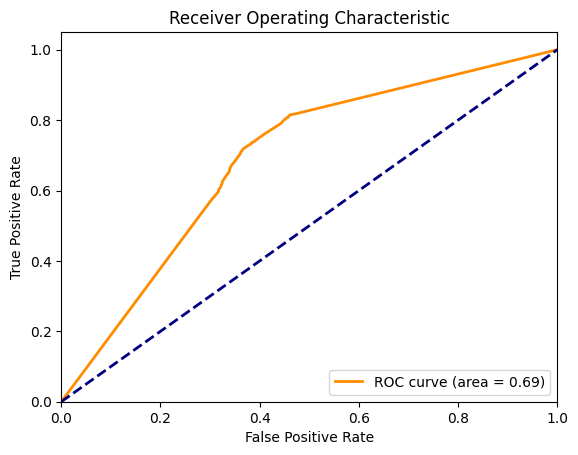

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


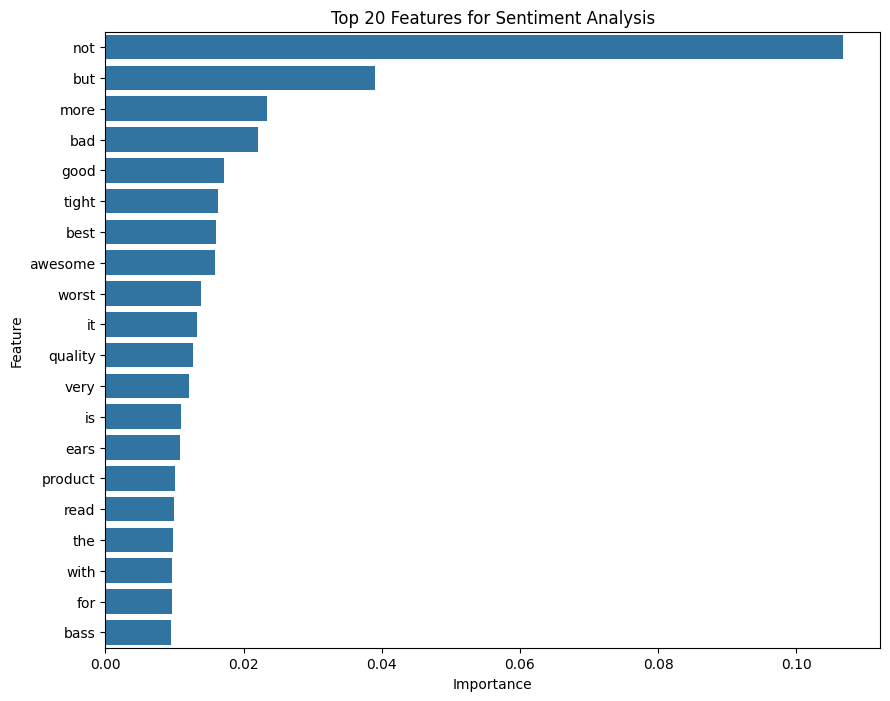

In [25]:
importances = model.feature_importances_
feature_names = cv.get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Features for Sentiment Analysis')
plt.show()


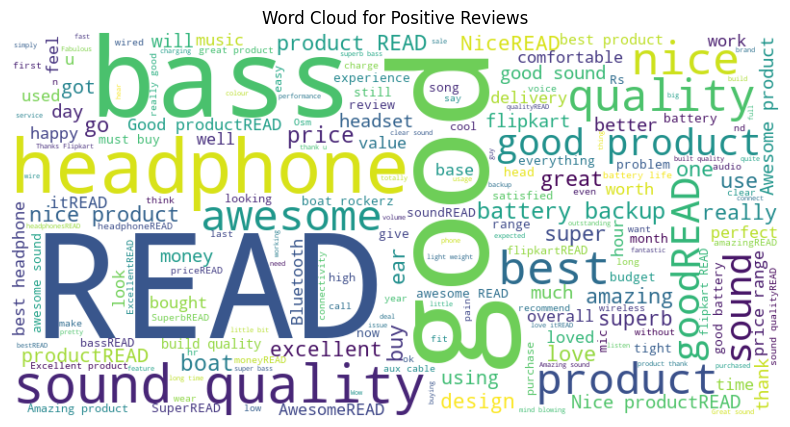

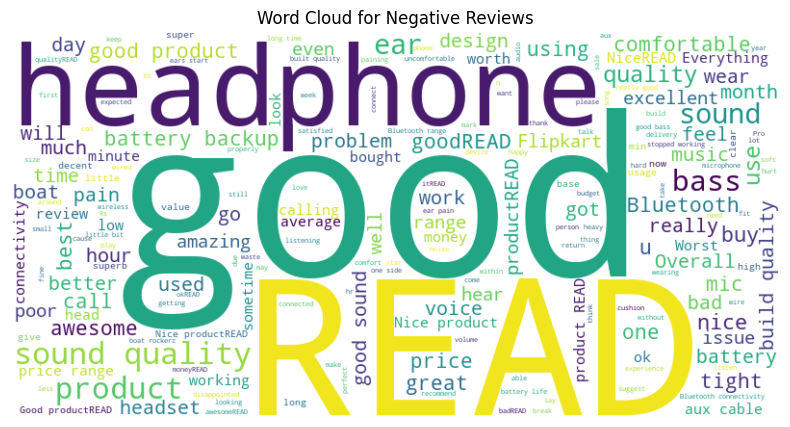

In [26]:
# Positive Reviews Word Cloud
positive_reviews = ' '.join(review for review in data['review'][data['label'] == 1])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Negative Reviews Word Cloud
negative_reviews = ' '.join(review for review in data['review'][data['label'] == 0])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()
